Training the model...

Evaluation Metrics:
Mean Squared Error: 12.940846271509153
Mean Absolute Error: 2.802284278768414
R-squared: 0.160810062214521


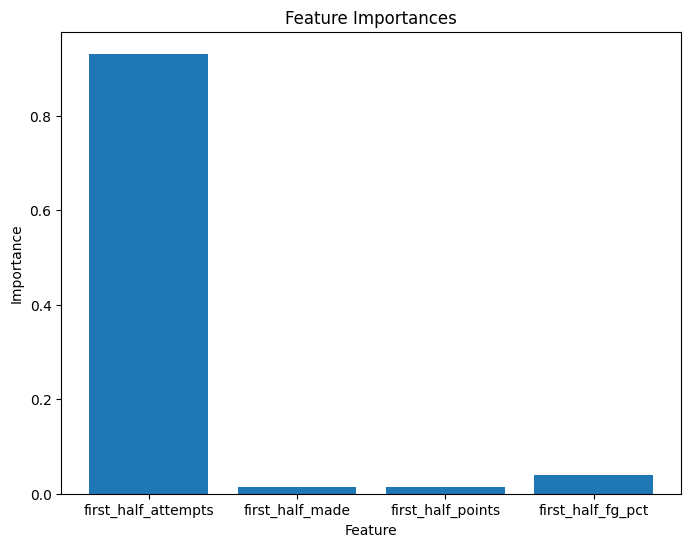


Model saved as 'player_performance_predictor.pkl'.
Predicted points in the second half for nikola jokic: 4.15


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import os

# -----------------------------
# Step 1: Data Processing & Model Training Function
# -----------------------------
def train_model():
    # Load the dataset
    df = pd.read_csv('/Users/richmondprado/Desktop/CSUN/2025/Comp 542/Project/COMP542_Project/23-24 NBA dataset.csv')

    # Data preprocessing
    df['SHOT_ATTEMPTED_FLAG'] = df['SHOT_ATTEMPTED_FLAG'].astype(int)
    df['SHOT_MADE_FLAG'] = df['SHOT_MADE_FLAG'].astype(int)
    df['SHOT_TYPE'] = df['SHOT_TYPE'].astype(str)
    df['PLAYER_NAME'] = df['PLAYER_NAME'].astype(str)

    # Filter to shot attempts (SHOT_ATTEMPTED_FLAG == 1)
    shots = df[df['SHOT_ATTEMPTED_FLAG'] == 1].copy()

    # Compute points scored for each shot:
    # If the shot is made (SHOT_MADE_FLAG == 1), assign 3 points for a "3PT" shot type, else 2 points.
    # If the shot is not made, points = 0.
    def calculate_points(row):
        if row['SHOT_MADE_FLAG'] == 1:
            if row['SHOT_TYPE'] == '3PT':
                return 3
            else:
                return 2
        return 0

    shots['POINTS'] = shots.apply(calculate_points, axis=1)

    # Aggregate data by GAME_ID, PLAYER_NAME, and PERIOD
    grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'PERIOD']).agg(
        attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
        made=('SHOT_MADE_FLAG', 'sum'),
        points=('POINTS', 'sum')
    ).reset_index()

    # Separate first and second half data
    first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        first_half_attempts=('attempts', 'sum'),
        first_half_made=('made', 'sum'),
        first_half_points=('points', 'sum')
    ).reset_index()

    second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        second_half_points=('points', 'sum')
    ).reset_index()

    # Merge first and second half data
    game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME'], how='inner')

    # Feature engineering: first-half shooting percentage
    game_player_data['first_half_fg_pct'] = game_player_data.apply(
        lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
        axis=1
    )

    # Define features (X) and target (y)
    X = game_player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    y = game_player_data['second_half_points']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Feature importance visualization
    importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.bar(X.columns, importances)
    plt.title("Feature Importances")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

    # Save the trained model
    joblib.dump(model, 'player_performance_predictor.pkl')
    print("\nModel saved as 'player_performance_predictor.pkl'.")


# -----------------------------
# Prediction Function
# -----------------------------
def predict_player_performance(player_name):
    # Check if the model file exists
    if not os.path.exists('player_performance_predictor.pkl'):
        print("Model file does not exist. Please train the model first.")
        return

    # Load model and scaler
    model = joblib.load('player_performance_predictor.pkl')
    
    # Filter player data
    player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name.upper()]

    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return

    # Extract the relevant features and scale them
    player_data = player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    scaler = StandardScaler()
    player_data_scaled = scaler.fit_transform(player_data)

    # Predict the second-half points
    prediction = model.predict(player_data_scaled)
    print(f"Predicted points in the second half for {player_name}: {prediction[0]:.2f}")


# -----------------------------
# Main Function
# -----------------------------
def main():
    # Train the model
    print("Training the model...")
    train_model()

    # User Input
    player_name = input("Enter Player Name: ")
    if player_name.strip():
        predict_player_performance(player_name)
    else:
        print("Please enter a valid player name.")

if __name__ == "__main__":
    main()


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import os

# Mapping of team names to abbreviations
team_mapping = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "LA Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# -----------------------------
# Step 1: Data Processing & Model Training Function
# -----------------------------
def train_model():
    # Load the dataset
    df = pd.read_csv('23-24 NBA dataset.csv')

    # Data preprocessing
    df['SHOT_ATTEMPTED_FLAG'] = df['SHOT_ATTEMPTED_FLAG'].astype(int)
    df['SHOT_MADE_FLAG'] = df['SHOT_MADE_FLAG'].astype(int)
    df['SHOT_TYPE'] = df['SHOT_TYPE'].astype(str)
    df['PLAYER_NAME'] = df['PLAYER_NAME'].astype(str)

    # Filter to shot attempts (SHOT_ATTEMPTED_FLAG == 1)
    shots = df[df['SHOT_ATTEMPTED_FLAG'] == 1].copy()

    # Compute points scored for each shot:
    def calculate_points(row):
        if row['SHOT_MADE_FLAG'] == 1:
            if row['SHOT_TYPE'] == '3PT':
                return 3
            else:
                return 2
        return 0

    shots['POINTS'] = shots.apply(calculate_points, axis=1)

    # Aggregate data by GAME_ID, PLAYER_NAME, and PERIOD
    grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'PERIOD']).agg(
        attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
        made=('SHOT_MADE_FLAG', 'sum'),
        points=('POINTS', 'sum')
    ).reset_index()

    # Separate first and second half data
    first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        first_half_attempts=('attempts', 'sum'),
        first_half_made=('made', 'sum'),
        first_half_points=('points', 'sum')
    ).reset_index()

    second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        second_half_points=('points', 'sum')
    ).reset_index()

    # Merge first and second half data
    game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME'], how='inner')

    # Feature engineering: first-half shooting percentage
    game_player_data['first_half_fg_pct'] = game_player_data.apply(
        lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
        axis=1
    )

    # Define features (X) and target (y)
    X = game_player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    y = game_player_data['second_half_points']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Feature importance visualization
    importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.bar(X.columns, importances)
    plt.title("Feature Importances")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

    # Save the trained model
    joblib.dump(model, 'player_performance_predictor.pkl')
    print("\nModel saved as 'player_performance_predictor.pkl'.")


# -----------------------------
# Prediction Function
# -----------------------------
def predict_player_performance(player_name):
    # Check if the model file exists
    if not os.path.exists('player_performance_predictor.pkl'):
        print("Model file does not exist. Please train the model first.")
        return

    # Load model and scaler
    model = joblib.load('player_performance_predictor.pkl')
    
    # Filter player data for Jamal Murray
    player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name.upper()]

    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return

    # Map team and opponent names to abbreviations using the team_mapping
    player_data['TEAM'] = player_data['TEAM_NAME'].map(team_mapping)
    player_data['OPPONENT'] = player_data.apply(
        lambda row: team_mapping[row['AWAY_TEAM_NAME']] if row['TEAM_NAME'] == row['HOME_TEAM_NAME'] else team_mapping[row['HOME_TEAM_NAME']],
        axis=1
    )

    # Display statistics for Jamal Murray
    print("\nStatistics for Jamal Murray:")
    print(player_data[['PLAYER_NAME', 'TEAM', 'OPPONENT', 'GAME_DATE', 'first_half_points', 'second_half_points']])

    # Extract the relevant features and scale them
    player_data = player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    scaler = StandardScaler()
    player_data_scaled = scaler.fit_transform(player_data)

    # Predict the second-half points
    prediction = model.predict(player_data_scaled)
    print(f"Predicted points in the second half for {player_name}: {prediction[0]:.2f}")




Training the model...

Evaluation Metrics:
Mean Squared Error: 12.940846271509153
Mean Absolute Error: 2.802284278768414
R-squared: 0.160810062214521


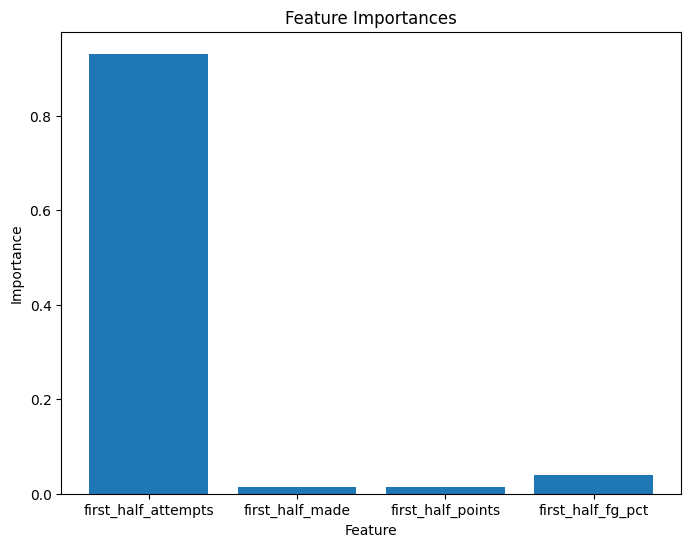


Model saved as 'player_performance_predictor.pkl'.
Predicted points in the second half for jamal murray: 2.91


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import os

# -----------------------------
# Step 1: Data Processing & Model Training Function
# -----------------------------
def train_model():
    # Load the dataset
    df = pd.read_csv('/Users/richmondprado/Desktop/CSUN/2025/Comp 542/Project/COMP542_Project/23-24 NBA dataset.csv')

    # Data preprocessing
    df['SHOT_ATTEMPTED_FLAG'] = df['SHOT_ATTEMPTED_FLAG'].astype(int)
    df['SHOT_MADE_FLAG'] = df['SHOT_MADE_FLAG'].astype(int)
    df['SHOT_TYPE'] = df['SHOT_TYPE'].astype(str)
    df['PLAYER_NAME'] = df['PLAYER_NAME'].astype(str)

    # Filter to shot attempts (SHOT_ATTEMPTED_FLAG == 1)
    shots = df[df['SHOT_ATTEMPTED_FLAG'] == 1].copy()

    # Compute points scored for each shot:
    # If the shot is made (SHOT_MADE_FLAG == 1), assign 3 points for a "3PT" shot type, else 2 points.
    # If the shot is not made, points = 0.
    def calculate_points(row):
        if row['SHOT_MADE_FLAG'] == 1:
            if row['SHOT_TYPE'] == '3PT':
                return 3
            else:
                return 2
        return 0

    shots['POINTS'] = shots.apply(calculate_points, axis=1)

    # Aggregate data by GAME_ID, PLAYER_NAME, and PERIOD
    grouped = shots.groupby(['GAME_ID', 'PLAYER_NAME', 'PERIOD']).agg(
        attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),
        made=('SHOT_MADE_FLAG', 'sum'),
        points=('POINTS', 'sum')
    ).reset_index()

    # Separate first and second half data
    first_half = grouped[grouped['PERIOD'].isin([1, 2])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        first_half_attempts=('attempts', 'sum'),
        first_half_made=('made', 'sum'),
        first_half_points=('points', 'sum')
    ).reset_index()

    second_half = grouped[grouped['PERIOD'].isin([3, 4])].groupby(['GAME_ID', 'PLAYER_NAME']).agg(
        second_half_points=('points', 'sum')
    ).reset_index()

    # Merge first and second half data
    game_player_data = pd.merge(first_half, second_half, on=['GAME_ID', 'PLAYER_NAME'], how='inner')

    # Feature engineering: first-half shooting percentage
    game_player_data['first_half_fg_pct'] = game_player_data.apply(
        lambda row: row['first_half_made'] / row['first_half_attempts'] if row['first_half_attempts'] > 0 else 0,
        axis=1
    )

    # Define features (X) and target (y)
    X = game_player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    y = game_player_data['second_half_points']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Feature importance visualization
    importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.bar(X.columns, importances)
    plt.title("Feature Importances")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

    # Save the trained model
    joblib.dump(model, 'player_performance_predictor.pkl')
    print("\nModel saved as 'player_performance_predictor.pkl'.")


# -----------------------------
# Prediction Function
# -----------------------------
def predict_player_performance(player_name):
    # Check if the model file exists
    if not os.path.exists('player_performance_predictor.pkl'):
        print("Model file does not exist. Please train the model first.")
        return

    # Load model and scaler
    model = joblib.load('player_performance_predictor.pkl')
    
    # Filter player data
    player_data = game_player_data[game_player_data['PLAYER_NAME'].str.upper() == player_name.upper()]

    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return

    # Extract the relevant features and scale them
    player_data = player_data[['first_half_attempts', 'first_half_made', 'first_half_points', 'first_half_fg_pct']]
    scaler = StandardScaler()
    player_data_scaled = scaler.fit_transform(player_data)

    # Predict the second-half points
    prediction = model.predict(player_data_scaled)
    print(f"Predicted points in the second half for {player_name}: {prediction[0]:.2f}")


# -----------------------------
# Main Function
# -----------------------------
def main():
    # Train the model
    print("Training the model...")
    train_model()

    # User Input
    player_name = input("Enter Player Name: ")
    if player_name.strip():
        predict_player_performance(player_name)
    else:
        print("Please enter a valid player name.")

if __name__ == "__main__":
    main()
